# Gene expression profiles to identify cancer types

## Importing Libraries

In [49]:
#Installing UMAP
pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 355.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 556.9 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
#data manipulation
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import os

#feature selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

#Classification
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report

## Reading the data file

This dataset contain two files:

data.csv is the gene expression data matrix where the columns are genes (features), and the rows correspond to samples (patients).

labels.csv contain information about the type of cancer each patient have.

In [6]:
#read data from github?
# Define the base directory for the data files
# Define the raw URLs for the data files
base_dir = '../data/raw/'


# Construct the full paths
data_path = os.path.join(base_dir, 'data.csv')
labels_path = os.path.join(base_dir, 'labels.csv')

dt = pd.read_csv(data_path, index_col = 0)
lb = pd.read_csv(labels_path, index_col = 0)

## Data exploration and cleaning

In [7]:
#merging the data with labels

data_frame = pd.merge(dt, lb, left_index=True, right_index=True)
print(data_frame.columns)
print (data_frame.shape)

#Rename last column as Cancer_Type
data_frame = data_frame.rename(columns={'Class': 'Cancer_Type'})
print(data_frame.columns)

Index(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6',
       'gene_7', 'gene_8', 'gene_9',
       ...
       'gene_16374', 'gene_16375', 'gene_16376', 'gene_16377', 'gene_16378',
       'gene_16379', 'gene_16380', 'gene_16381', 'gene_16382', 'Class'],
      dtype='object', length=16384)
(590, 16384)
Index(['gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5', 'gene_6',
       'gene_7', 'gene_8', 'gene_9',
       ...
       'gene_16374', 'gene_16375', 'gene_16376', 'gene_16377', 'gene_16378',
       'gene_16379', 'gene_16380', 'gene_16381', 'gene_16382', 'Cancer_Type'],
      dtype='object', length=16384)


The dataset contain 590 samples (individuals) and 16384 genes (features)

In [8]:
#Check for missing values - this summs the amount of null occurrences in the data set and safe the columns with null values in variable null
datanull = data_frame.isnull().sum() 
null = [i for i in datanull if i > 0]

print('The columns with missing values are:%d'%len(null))

The columns with missing values are:0


This datas set doesn't contain missing values

Cancer_Type
BRCA    215
LUAD    109
KIRC    107
PRAD    101
COAD     58
Name: count, dtype: int64


Text(0.5, 1.0, 'Amount of samples per cancer type')

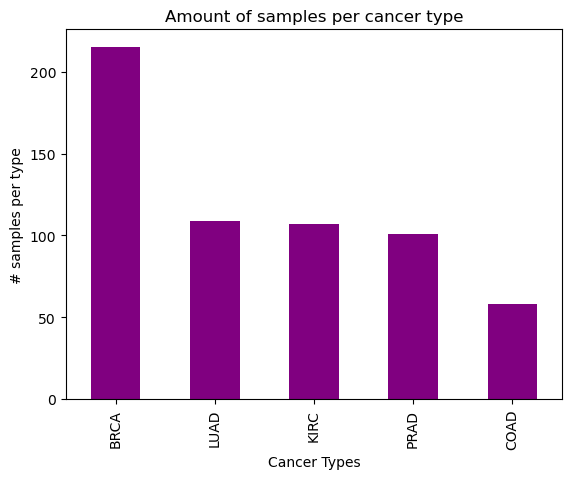

In [9]:
#Checking how many type of cancer we have
print(data_frame['Cancer_Type'].value_counts())

#Visualizing
data_frame['Cancer_Type'].value_counts().plot.bar(color='purple')

# Add labels and title
plt.xlabel('Cancer Types')
plt.ylabel('# samples per type')
plt.title('Amount of samples per cancer type')

The dataset contains 5 groups of patients with 5 diferent types of cancer: 

* BRCA    Breast Cancer
* LUAD    Luncg Cancer
* KIRC    Kindey Cancer
* PRAD    Protate Cancer
* COAD    Colon Cancer

In [10]:
#Separating feature values from class (cancer type)
X = data_frame.iloc[:, :-1]  # Features (gene expression levels)
y = data_frame.iloc[:, -1]   # Target variable (last column)


#### Encoding the lables 
Since the class (cancer type) is categorical we will need to convert (encode) them to numeric to be able to perform the analysis.

In [11]:
#using LabelEncoder from sklearn 
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)
labels = label_encoder.classes_
classes = np.unique(y_encoded)
print(labels)
print(classes)

['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
[0 1 2 3 4]


### Data spliting

This section will allow us to split the data into training and testing subsets. 

In [23]:
#spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y_encoded,test_size=0.2, random_state=42)


### Data normalization

This will imporve the model performace, it will set the values to the same range.

In [24]:
# Initialize MinMaxScaler
min_max_scaler = MinMaxScaler()

# Fit and transform the training data
X_train_norm = min_max_scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_norm = min_max_scaler.transform(X_test)

### Feature Selection

In this stage, after some research we decide to use mutual_info_classif to do feature selection.

In [25]:
mic_features = mutual_info_classif(X_train_norm,y_train)

In [26]:
#arbitrarily selected top 200 features
#you can modify the value and see how the performance of the model changes

n_features=200
selected_scores_indices=np.argsort(mic_features)[::-1][0:n_features]

In [27]:
#setting up the groups
X_train_selected=X_train_norm[:,selected_scores_indices]
X_test_selected=X_test_norm[:,selected_scores_indices]

In [28]:
X_train_selected.shape

(472, 200)

In [29]:
X_test_selected.shape

(118, 200)

### Classification

For the purpose of this project we are doing a regression, first we try using linnear regression

In [30]:
# Initialize linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train_selected, y_train)

# Predict on the test data
y_pred = model.predict(X_test_selected)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 0.09
R-squared: 0.96


The error of 0.09 seems to be good, now we do some visualization to make sure the results look good

 ### Visualization of the results


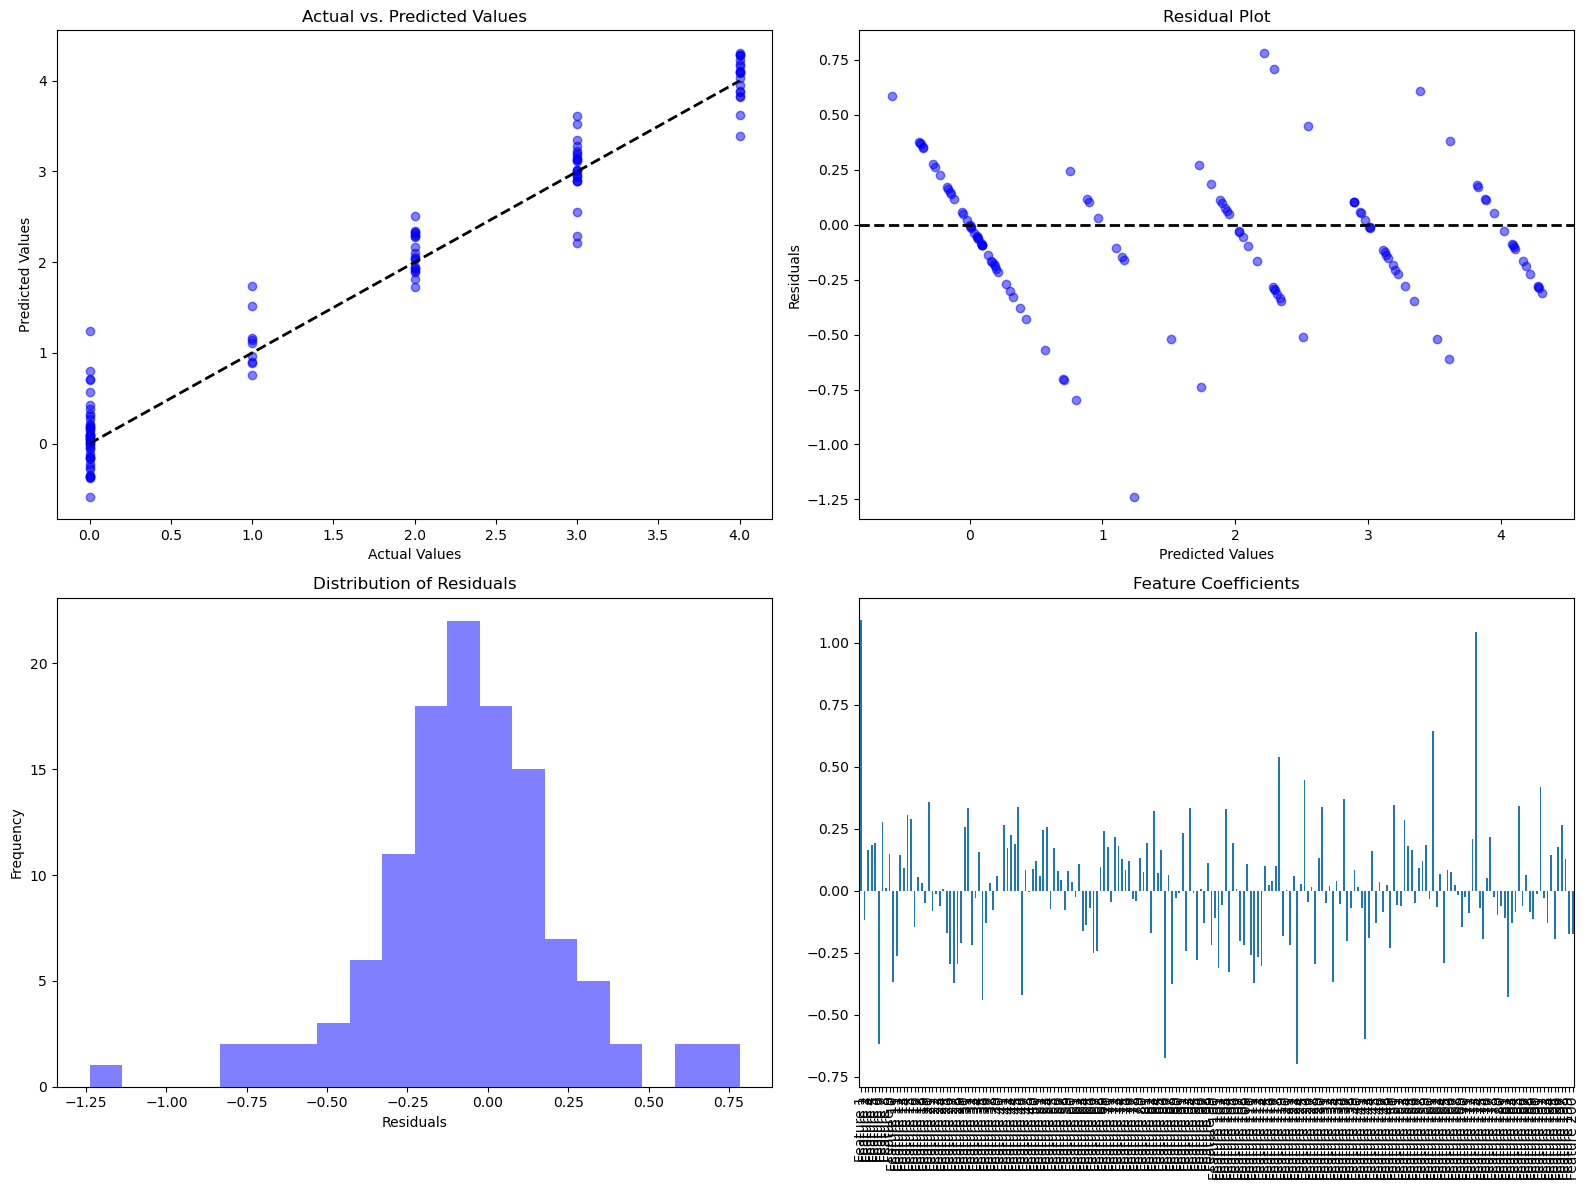

In [36]:
# Create a figure with 4 subplots (2 rows, 2 columns)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot of actual vs. predicted values
ax1.scatter(y_test, y_pred, color='blue', alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('Actual vs. Predicted Values')

# Residual plot
ax2.scatter(y_pred, y_test - y_pred, color='blue', alpha=0.5)
ax2.axhline(y=0, color='k', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')

# Distribution plot of residuals
ax3.hist(y_test - y_pred, bins=20, color='blue', alpha=0.5)
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Residuals')

# Coefficient plot (if applicable)
if model is not None and hasattr(model, 'coef_'):
    if isinstance(X_train_selected, np.ndarray):
        coefs = pd.Series(model.coef_, index=[f'Feature {i+1}' for i in range(X_train_selected.shape[1])])
        coefs.plot(kind='bar', ax=ax4)
        ax4.set_title('Feature Coefficients')

plt.tight_layout()
plt.show()

 #### Scatter Plot of Actual vs. Predicted Values
 Points clustered closely around the diagonal line indicate accurate predictions. Deviations from this line suggest where the model overpredicts or underpredicts.

#### Residual Plot

The residual plot shows the residuals (difference between actual and predicted values) against the predicted values.

Ideally, residuals should be randomly scattered around the horizontal line at y=0, without any clear pattern. Patterns could indicate heteroscedasticity or other issues with the model.

#### Distribution of Residuals
Visualizing the distribution of residuals can provide insights into the model's performance. Residuals ideally should be normally distributed around 0. Skewness or heavy tails indicate bias in the model.

#### Coefficient Plot

Show which features are most influential in predicting the target variable. Larger coefficients (positive or negative) indicate stronger influence of the corresponding feature on the target variable.

Even though the error was very low the figures show a possible overfitting of the data.

### Testing linear regression 

Now we are trying a logistic regression

In [38]:
# Initialize logistic regression model
model_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

# Fit the model on the training data
model_lr.fit(X_train_selected, y_train)

# Predict on the test data
y_pred_lr = model_lr.predict(X_test_selected)

# Evaluate model performance
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        23
           4       1.00      1.00      1.00        19

    accuracy                           1.00       118
   macro avg       1.00      1.00      1.00       118
weighted avg       1.00      1.00      1.00       118



In [39]:
#confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
print(cm)


[[48  0  0  0  0]
 [ 0  9  0  0  0]
 [ 0  0 19  0  0]
 [ 0  0  0 23  0]
 [ 0  0  0  0 19]]


The logistic regression showed a pefect classification, even though doing more research about RNA-sec data we realize that due to the hogh dimentionality of this type of data the best way to do feature selestion is through dimentionality reduction. 

Now we will be testing PCA, t-SNE and UMAP to do so.

## Dimensionality Reduction

#### PCA
Here, we are testing a different way to reduce dimensionality by using Principal Component Analysis

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


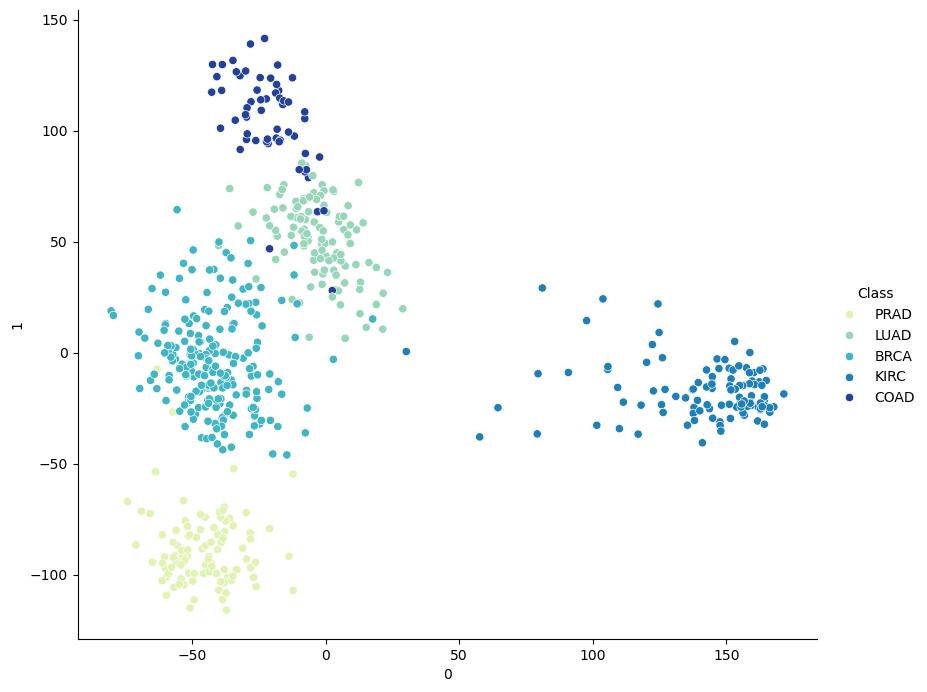

In [40]:
#reading the data to fit the PCA needs
data = pd.read_csv(data_path)
labels = pd.read_csv(labels_path)

X = data.drop(data.columns[0],axis=1)
Y = labels.Class

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
X_pca = pd.DataFrame(data = principalComponents)
X_pca = pd.concat([X_pca.reset_index().drop(['index'],axis=1),Y.reset_index().drop(['index'],axis=1)], axis=1)

sns.pairplot(x_vars=0, y_vars=1, data=X_pca, hue="Class",palette="YlGnBu",size=7,aspect=1.2)
plt.show()

#### t-SNE reduction

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


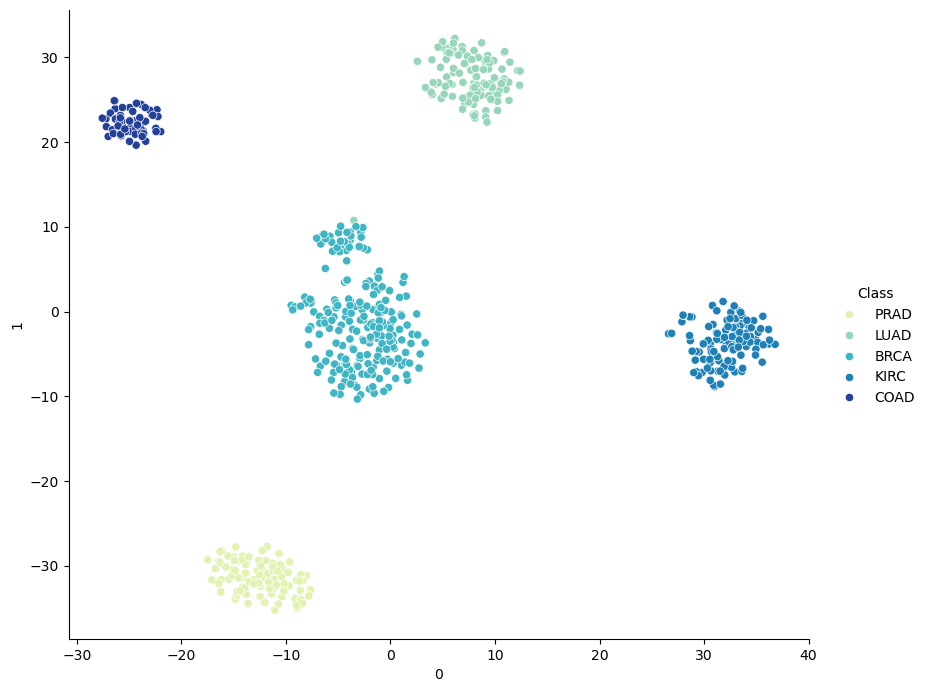

In [42]:
X_tsne = TSNE(n_components=2).fit_transform(X)
X_tsne = pd.DataFrame(data = X_tsne)
X_tsne = pd.concat([X_tsne.reset_index().drop(['index'],axis=1),Y.reset_index().drop(['index'],axis=1)], axis=1)

sns.pairplot(x_vars=0, y_vars=1, data=X_tsne, hue="Class",palette="YlGnBu",size=7,aspect=1.2)
plt.show()

In [ ]:
X = X_tsne .drop(['Class'],axis=1)
Y = X_tsne ['Class']

#spliting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X,y_encoded,test_size=0.2, random_state=42)

t-sne seems to be doing a better job than PCA to separate the 5 types of cancer, so we are using this results to perform our regression test